# Multi Color Light Curves  applied to LATISS DZP on CCD


- author Sylvie Dagoret-Campagne
- creation date 2024-05-03
- last update 2024-07-29
- last update 2024-09-06 : rerun to generate one uniformity plot and extract only one plot for non uniformity

w_2024_16
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [3]:
from shapely.geometry import Point as shapelyPoint
from shapely.geometry.polygon import Polygon as shapelyPolygon

In [4]:
def is_in_polygon(x,y,ll,lr,ur,ul):
    point = shapelyPoint(x, y)
    polygon = shapelyPolygon([ll, lr, ur, ul])
    return polygon.contains(point)

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def isradec_inbbox_radec(ra,dec,ramin,ramax,decmin,decmax):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """


    flag_ra = angle_in_range(ra,ramin,ramax)
    flag_dec = angle_in_range(dec,decmin,decmax)

    flag = flag_ra and flag_dec
    return flag


In [7]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [8]:
saveDir = "./lc_output_dmrehearsal2024-latiss"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [9]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux =  50 #100

In [10]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
#collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240414/w_2024_15/PREOPS-5069' 
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240513/w_2024_20/PREOPS-5146' # test this one today 2024/06/22
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_35_0_instFlux"
calibFluxErrStr = "apFlux_35_0_instFluxErr"
calibFluxMagStr = "apFlux_35_0_instMag"
calibFluxMagErrStr = "apFlux_35_0_instMagErr"

calibFluxCalStr = "apFlux_35_0_calFlux"
calibFluxCalErrStr = "apFlux_35_0_calFluxErr"
calibFluxCalMagStr = "apFlux_35_0_calMag"
calibFluxCalMagErrStr = "apFlux_35_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03-latiss-tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [11]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240513/w_2024_20/PREOPS-5146']


## load isolated_star_sources

In [12]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10643}
1 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3863}
2 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 380}
3 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 8188}
4 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 454}
5 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10644}
6 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5634}
7 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5616}
8 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5615}
9 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 382}
10 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3864}
11 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 455}
12 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 452}
13 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5614}
14 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 383}
15 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5839}
all tracts :  [380, 382, 383, 452, 454, 455, 3863, 386

## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [13]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [14]:
tract

3864

In [15]:
len(isolatedStarSourcesFull)

299647

In [16]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,719,178244558356742864,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.946305,580.063968,3089.021146,3522.955646,18546.113866,817.794717,False,-0.065356,False,719,0


In [17]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,719,178244558356742864,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.946305,580.063968,3089.021146,3522.955646,18546.113866,817.794717,False,-0.065356,False,719,0
1,661,178244564799193750,2023111500499,0,122.502820,-36.181372,empty~SDSSi_65mm,i,17967.430086,593.565729,1981.052886,3539.434078,18792.440052,839.011243,False,0.042199,False,661,0
2,693,178244568020419254,2023111500502,0,122.502819,-36.181372,empty~SDSSi_65mm,i,17308.973217,581.983397,1425.831660,3545.340826,17904.927125,821.413552,False,0.075495,False,693,0
3,476,178244580905320925,2023111500514,0,122.502817,-36.181374,empty~SDSSi_65mm,i,16560.712209,545.671588,3634.994233,2036.355912,16303.119580,776.241811,False,-0.194217,False,476,0
4,435,178244587347771828,2023111500520,0,122.502822,-36.181372,empty~SDSSi_65mm,i,17947.571729,577.548601,2527.386052,2051.742370,18615.699872,814.688326,False,0.040216,False,435,0


In [18]:
isolatedStarSourcesFull.tail()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
299642,311,181973652974076216,2024022900075,0,122.477861,-36.067847,empty~SDSSy_65mm,y,17262.726647,589.125479,1210.733326,3710.297656,17598.611697,831.424850,False,0.074381,False,311,1378
299643,55,179546353280483384,2023122200468,0,122.636922,-36.166699,empty~SDSSy_65mm,y,6155.494511,570.340900,4029.261866,467.716017,NaN,NaN,True,-0.121130,False,55,1379
299644,230,182712628940898535,2024032100172,0,122.422806,-36.197233,empty~SDSSy_65mm,y,14495.007492,633.053916,1810.955084,1261.710726,15416.204208,907.111443,False,0.593289,False,230,1380
299645,220,182712628940898525,2024032100172,0,122.380778,-36.198893,empty~SDSSy_65mm,y,7354.527094,668.102048,534.384855,1214.978668,8179.358158,942.475658,False,0.315391,False,220,1381
299646,7,178913118334746632,2023120400546,0,122.627448,-36.261951,empty~SDSSy_65mm,y,5915.164322,546.429347,3854.515724,69.444468,4937.504225,779.708809,False,-0.274914,False,7,1382


In [19]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [20]:
#print(sorted(isolatedStarSourcesFull["visit"].unique()))

In [21]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,719,178244558356742864,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.946305,580.063968,3089.021146,3522.955646,18546.113866,817.794717,False,-0.065356,False,719,0


In [22]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [23]:
calibFluxStr

'apFlux_35_0_instFlux'

In [24]:
minSnCalibFlux

50

In [25]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=83607 matched sources from original 299647)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 367 objects from 1383).


In [26]:
sorted_visitList = sorted(visitList)
#sorted_visitList 

In [27]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [28]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [29]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [30]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [31]:
#visitList

In [32]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
# The selected sources from the sourceTable_visit will go in a list inside the sourceCatalog
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit and load sourceTable_visit visit per visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 2023112000367
sourceTable_visit not found for visit 2024031200224
sourceTable_visit not found for visit 2024031200247
sourceTable_visit not found for visit 2024031200252
sourceTable_visit not found for visit 2024031200259
sourceTable_visit not found for visit 2024031200276
sourceTable_visit not found for visit 2024031200308
sourceTable_visit not found for visit 2024020600055
sourceTable_visit not found for visit 2023111600708
sourceTable_visit not found for visit 2023113000525
sourceTable_visit not found for visit 2023113000529
sourceTable_visit not found for visit 2023113000528
sourceTable_visit not found for visit 2024030100072
sourceTable_visit not found for visit 2024020700339
sourceTable_visit not found for visit 2024022900076
sourceTable_visit not found for visit 2024020700350
sourceTable_visit not found for visit 2024040900482
sourceTable_visit not found for visit 2024012900356
sourceTable_visit not found for visit 2024032900433
sourceTable_

In [33]:
len(sourceCatalogs)

4473

In [34]:
#nSourceDict

In [35]:
#visitList

In [36]:
visitsToRemove 

[2023112000367,
 2024031200224,
 2024031200247,
 2024031200252,
 2024031200259,
 2024031200276,
 2024031200308,
 2024020600055,
 2023111600708,
 2023113000525,
 2023113000529,
 2023113000528,
 2024030100072,
 2024020700339,
 2024022900076,
 2024020700350,
 2024040900482,
 2024012900356,
 2024032900433,
 2024020800027,
 2024022600054,
 2024022600055,
 2024041600355,
 2023111600638,
 2023111600640,
 2024031300128,
 2024031300131,
 2023111600684,
 2023111600688,
 2023112000360,
 2024020700276,
 2024020700277,
 2024020700280,
 2024020700282,
 2024020700286,
 2024020700290,
 2024020800062,
 2024020700303,
 2024020700304,
 2024020700306,
 2024020700305,
 2024020700317,
 2024020700318,
 2024020700319,
 2024020700331,
 2024020700334,
 2024020700349,
 2024020700358,
 2024020800072,
 2024020800039,
 2024020800040,
 2024040900462,
 2024030400161,
 2024032800424,
 2024032800425,
 2024032800462,
 2024020800024,
 2024020800044,
 2024020800043,
 2024020800047,
 2024020800053,
 2024020800055,
 2024020

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### retrieve the CCD Visit Table

- it provides airmass and initial zero-point

In [37]:
ccdVisitTable = butler.get("ccdVisitTable")

In [38]:
ccdVisitTable

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.689255,7.759873,11.193549,7.856800,0.025776,0.025776,25,-0.021610,-0.001727,0.027830,0.002436,0.066038,0.036761,0.004676,0.405671,2057.208740,0.210246,0.016607,2.680115,0.157457,-24.053747,0,1.748842,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.857122,6.321881,28.073927,8.586373,0.026761,0.026761,36,0.004348,-0.017695,0.039457,0.038433,0.016566,0.088571,0.013995,0.303527,1387.484985,0.172069,0.025021,1.068607,0.214514,-24.036848,0,1.424821,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.772554,8.043074,10.700970,7.854424,0.024561,0.024561,15,-0.002856,-0.009528,0.012457,0.002901,0.129572,0.091544,0.011143,0.401846,2265.302246,0.238658,0.015458,2.803484,0.183570,-24.045512,0,1.812574,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.859636,6.754847,23.952974,8.440454,0.023946,0.023946,24,-0.006401,0.005997,0.036388,0.022835,-0.003559,0.056631,0.008252,1.230267,2129.429688,0.177468,0.021916,1.252454,0.215510,-24.046364,0,1.522426,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534
40919699200,2023051100271,SDSSi_65mm~empty,i,239.977384,-24.051453,53.394787,27.829411,6.488425,23.321407,8.416399,0.028203,0.028203,29,-0.001410,0.001387,0.026839,0.013898,0.008566,0.101609,0.015674,0.389506,1594.576904,0.186851,0.023753,1.286372,0.203839,-24.051453,0,1.462219,324.227336,2023-05-12 01:24:47.058502,60076.058878,30.0,2023-05-12 01:24:32.058502,60076.058704,30.2432,4071,3999,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43847346432,2024042400361,empty~SDSSy_65mm,y,122.434372,-36.155786,32.712715,26.077629,6.662502,15.791055,8.105496,0.021017,0.021017,25,-0.000103,-0.002732,0.017352,0.018965,0.037941,0.102216,0.014327,0.440332,1644.404053,0.010385,0.022528,1.899810,0.008088,-36.155786,0,1.501436,359.999657,2024-04-25 01:14:18.256500,60425.051600,30.0,2024-04-25 01:14:03.256500,60425.051427,30.2377,4071,3999,122.368131,-36.209613,122.502275,-36.208248,122.500521,-36.101922,122.366559,-36.103285
43847350784,2024042400378,SDSSg_65mm~empty,g,122.454716,-36.163586,35.288021,28.009708,7.552599,37.548855,9.104710,0.029800,0.029800,31,0.010034,-0.005513,0.032524,0.015818,0.098800,0.097028,0.012428,0.914790,1700.441772,0.119392,0.017531,0.798959,0.284135,-36.163586,0,1.702023,359.999744,2024-04-25 01:27:07

In [39]:
ccdVisitTable_subset = ccdVisitTable.iloc[:20][["visitId","detector","band"]]
ccdVisitTable_subset

,visitId,detector,band
ccdVisitId,,,
40919696896,2023051100262,0,r
40919697408,2023051100264,0,i
40919698432,2023051100268,0,r
40919698944,2023051100270,0,i
40919699200,2023051100271,0,i
40919699712,2023051100273,0,r
40919699968,2023051100274,0,r
40919700480,2023051100276,0,i
40919700736,2023051100277,0,i


In [40]:
ccdVisitTable.groupby(["visitId","ccdVisitId","detector"]).size()

visitId        ccdVisitId   detector
2023051100262  40919696896  0           1
2023051100264  40919697408  0           1
2023051100268  40919698432  0           1
2023051100270  40919698944  0           1
2023051100271  40919699200  0           1
                                       ..
2024042400361  43847346432  0           1
2024042400378  43847350784  0           1
2024042400379  43847351040  0           1
2024042400380  43847351296  0           1
2024042400381  43847351552  0           1
Length: 5889, dtype: int64

In [41]:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"])
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["detector"])
        break

ccdVisitId
42748468736    27.295219
Name: zeroPoint, dtype: float32
ccdVisitId
42748468736    0
Name: detector, dtype: int64


In [42]:
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)

In [43]:
# Collect useful columns from ccdVisitTable
# This is wrong when we have several detectors per visit
if 0:
    visitsCCDToRemove = []

    #Note there is one value per detector
    psfSigmaDict = {}
    skyBgDict = {}
    skyNoiseDict = {}
    expTimeDict = {}
    expMidptMjdDict = {}
    medianEDict = {}
    psfStarScaledDeltaSizeScatterDict = {}
    astromOffsetStdDict = {}
    psfTraceRadiusDeltaDict = {}
    zeroPointDict = {}
    airmassDict = {}
    seeingDict = {}

    # for visit in ccdVisitTable["visitId"].values:
    #     if visit in visitList:
    for visit in visitList:
        if visit in ccdVisitTable["visitId"].values:
            psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
            skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
            skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
            expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
            expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
            medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
            psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
            astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
            psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
            zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
            airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
            seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]

        else:
            #raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
            print("ERROR: CCD visit {} not found in ccdVisitTable".format(visit))
            visitsCCDToRemove.append(visit) 
            psfSigmaDict[visit] = np.nan
            skyBgDict[visit] = np.nan
            skyNoiseDict[visit] = np.nan
            expTimeDict[visit] = np.nan
            expMidptMjdDict[visit] = np.nan
            medianEDict[visit] = np.nan
            psfStarScaledDeltaSizeScatterDict[visit] = np.nan
            astromOffsetStdDict[visit] = np.nan
            psfTraceRadiusDeltaDict[visit] = np.nan
            zeroPointDict[visit] = np.nan
            airmassDict[visit] = np.nan
            seeingDict[visit] = np.nan

In [44]:
#visitList

In [45]:
#visitsToRemove 

In [46]:
# Just to have a look at what's in the catalog:
#ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

### Plot visits versus time

In [47]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expMidptMJD","obsStart","airmass","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

#### compute nightObs and datetime time

In [48]:
ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

/tmp/ipykernel_73746/2741161870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
/tmp/ipykernel_73746/2741161870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])


In [49]:
ccdVisitTable_g = ccdVisitTable_subset[ccdVisitTable_subset.band== "g"]
ccdVisitTable_r = ccdVisitTable_subset[ccdVisitTable_subset.band== "r"]
ccdVisitTable_i = ccdVisitTable_subset[ccdVisitTable_subset.band== "i"]
ccdVisitTable_z = ccdVisitTable_subset[ccdVisitTable_subset.band== "z"]
ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

In [50]:
ccdVisitTable_subset.head()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,r,27.689255,7.759873,11.193549,7.856800,1.748842,60076.047874,2023-05-12 01:08:41.302993,1.823818,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874,20230511,2023-05-12 01:08:41.302993
40919697408,2023051100264,i,27.857122,6.321881,28.073927,8.586373,1.424821,60076.052140,2023-05-12 01:14:49.912000,1.762794,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000
40919698432,2023051100268,r,27.772554,8.043074,10.700970,7.854424,1.812574,60076.055316,2023-05-12 01:19:24.311494,1.721301,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494
40919698944,2023051100270,i,27.859636,6.754847,23.952974,8.440454,1.522426,60076.057363,2023-05-12 01:22:21.150002,1.695170,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002
40919699200,2023051100271,i,27.829411,6.488425,23.321407,8.416399,1.462219,60076.058878,2023-05-12 01:24:32.058502,1.677014,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845,20230511,2023-05-12 01:24:32.058502


In [51]:
ccdVisitTable_subset.tail()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
43847346432,2024042400361,y,26.077629,6.662502,15.791055,8.105496,1.501436,60425.051600,2024-04-25 01:14:03.256500,1.188508,122.368131,-36.209613,122.502275,-36.208248,122.500521,-36.101922,122.366559,-36.103285,20240424,2024-04-25 01:14:03.256500
43847350784,2024042400378,g,28.009708,7.552599,37.548855,9.104710,1.702023,60425.060506,2024-04-25 01:26:52.749992,1.225102,122.388475,-36.217405,122.522634,-36.216054,122.520867,-36.109729,122.386890,-36.111079,20240424,2024-04-25 01:26:52.749992
43847351040,2024042400379,r,27.818642,6.392404,23.994133,8.569169,1.440662,60425.061049,2024-04-25 01:27:39.652002,1.227499,122.388599,-36.217430,122.522789,-36.216072,122.521026,-36.109759,122.387018,-36.111114,20240424,2024-04-25 01:27:39.652002
43847351296,2024042400380,z,27.284430,5.944799,20.052355,8.345500,1.339631,60425.061592,2024-04-25 01:28:26.512509,1.229912,122.388784,-36.217426,122.522936,-36.216061,122.521171,-36.109741,122.387201,-36.111105,20240424,2024-04-25 01:28:26.512509
43847351552,2024042400381,y,26.054819,6.300735,15.292327,8.068969,1.420020,60425.062144,2024-04-25 01:29:14.276508,1.232388,122.389157,-36.217383,122.523332,-36.216014,122.521578,-36.109686,122.387584,-36.111053,20240424,2024-04-25 01:29:14.276508


### Search for removed visit in CCD Visit Tables

In [52]:
ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False) 
ccdVisitTable_subset_removed = ccdVisitTable_subset[ccdVisitTable_subset["removed"]] 
ccdVisitTable_subset_removed 

/tmp/ipykernel_73746/1432482308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False)


,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,removed
ccdVisitId,,,,,,,,,,,,,,,,,,,,,


#### Thus the visit IN isolated-star_sources and MISSING in sourceTable are also NOT in ccdVisitTable !!!

In [53]:
# function of time conversion
from astropy.time import Time

def dt_to_mjd(dt):
    t = Time(dt)
    return t.to_value('mjd','float')

def mjd_to_dt(mjd):
    tm = Time(mjd, format='mjd')
    # Convert to datetime
    utc =tm.to_datetime()
    return utc

In [54]:
dt = ccdVisitTable_subset.iloc[0]['Time']
dt

Timestamp('2023-05-12 01:08:41.302993')

In [55]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [56]:
mjd = dt_to_mjd(dt)
mjd

60076.04770026612

In [57]:
tm = mjd_to_dt(mjd)

In [58]:
#ax.secondary_xaxis?

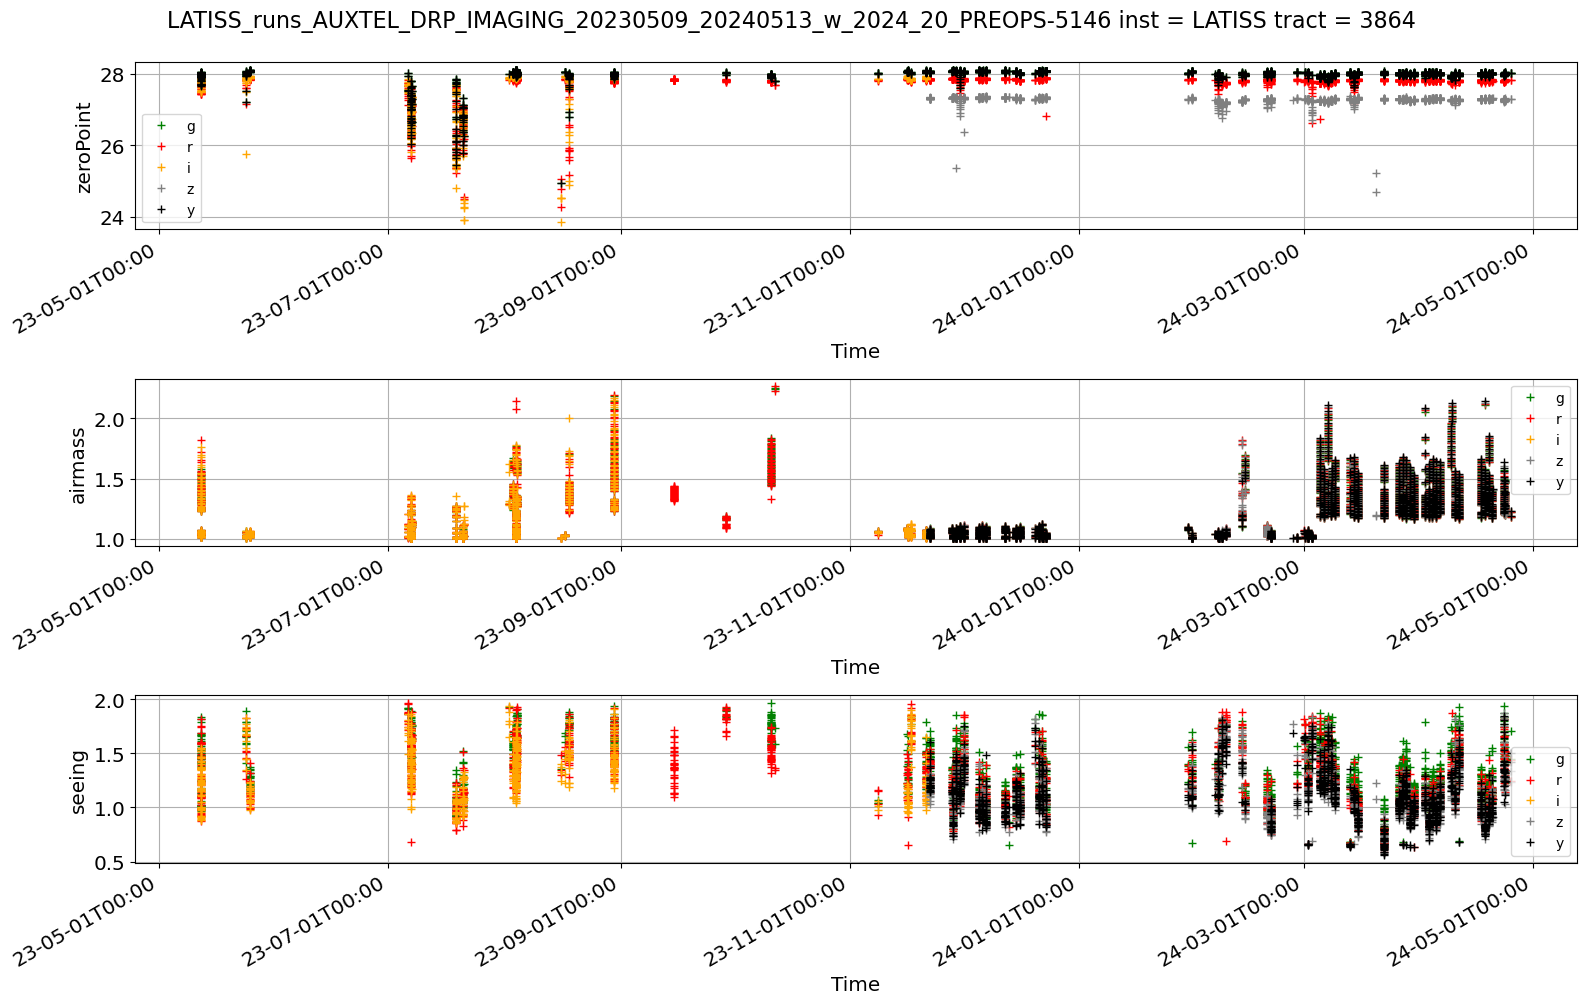

In [59]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)




#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()



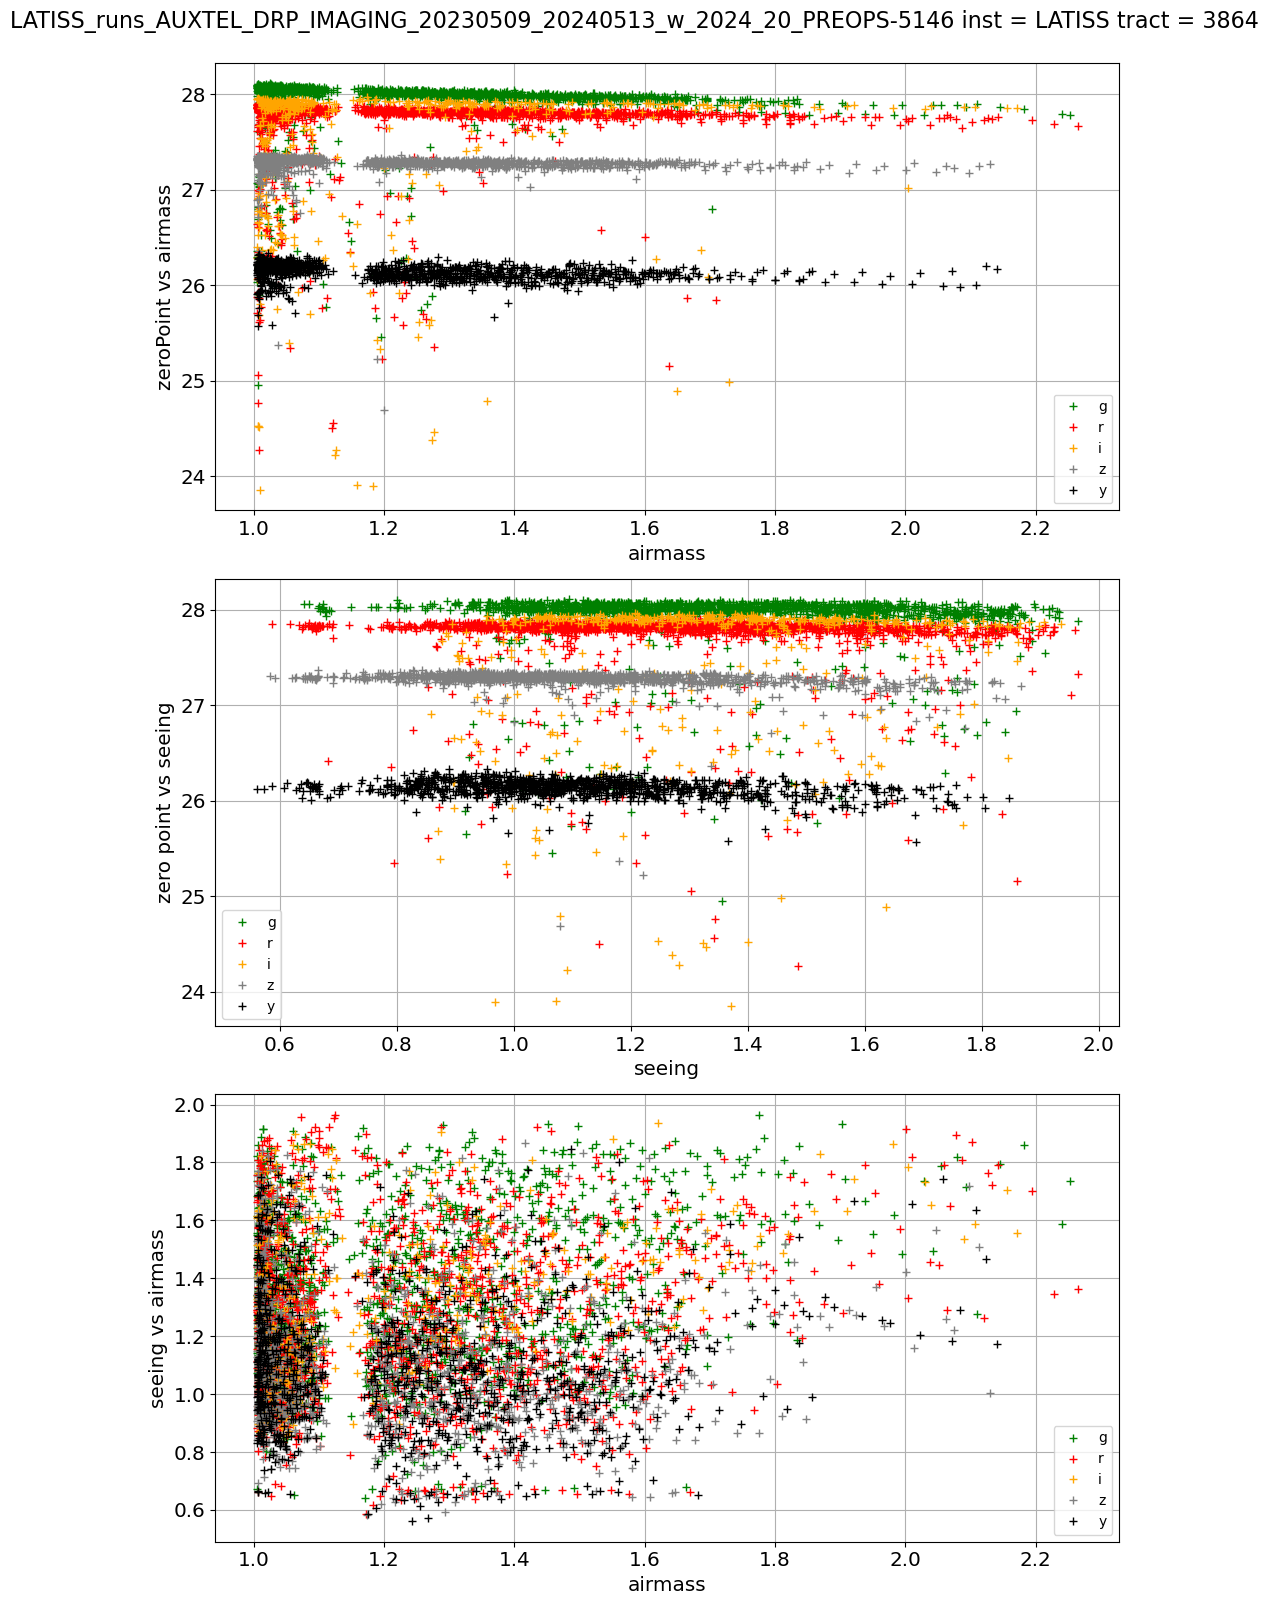

In [60]:
fig,axs = plt.subplots(3,1,figsize=(10,16))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="airmass",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint vs airmass")
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")

ccdVisitTable_g.plot(x="seeing",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="seeing",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="seeing",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="seeing",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="seeing",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_g.plot(x="airmass",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Come-back to dataJoined

In [61]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

### recalculate sources properties inside dataJoined before adding CCDVisit info

In [62]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]

### Extract info from CCDVisit

In [63]:
# Example of apply function format  that does what we expect
# dataJoined[["ra","dec"]].apply(lambda x: pd.Series([x["ra"], x["dec"]], index=['ra_2', 'dec_2']), axis=1)

In [64]:
# Example of function calculating in which detector is the source
def findCCDVisitPerSource(x):
    """
    Find the CCD visit cooresponding to that source
    """
    visitId = x["visit"]
    ra0 = x["ra"]
    dec0 = x ["dec"]
    ccd_visit_table_forthatvisit = ccdVisitTable[ccdVisitTable.visitId == visitId]
    ccd_visit_table_forthatvisit["select"] =  ccd_visit_table_forthatvisit.apply(lambda x :  is_in_polygon(ra0,dec0,(x["llcra"],x["llcdec"]), (x["lrcra"],x["lrcdec"]), (x["urcra"],x["urcdec"]),(x["ulcra"],x["ulcdec"])),axis=1)
    ccd_visit_table_forthatvisit = ccd_visit_table_forthatvisit[ccd_visit_table_forthatvisit["select"]] 
    ccd_visit_table_forthatvisit["dra"] = ra0 - ccd_visit_table_forthatvisit["ra"] 
    ccd_visit_table_forthatvisit["ddec"] = dec0 - ccd_visit_table_forthatvisit["dec"] 
    ccd_visit_table_forthatvisit.reset_index(inplace=True)
    ccd_visit_table_forthatvisit.rename(columns = {'ccdVisitId':'ccd_ccdVisitId',"visitId": "ccd_visitId","band":"ccd_band","detector":"ccd_detector"}, inplace = True) 
    ccd_visit_table_forthatvisit.drop(columns = ["physical_filter","ra","dec","select"],inplace=True)
    
    assert len(ccd_visit_table_forthatvisit == 1)
    # Convert the dataframe into a pandas series
    # Do not do ccd_visit_table_forthatvisit.T
    ser =  ccd_visit_table_forthatvisit.iloc[0,:]
    ser.name = "ccd_visit_table_forthatvisit"
    return ser

In [65]:
dataJoined_subset = dataJoined.iloc[:10]
dataJoined_subset_toadd = dataJoined_subset.apply(findCCDVisitPerSource,axis=1)
dataJoined_subset_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273
1,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.020762,-0.049820
2,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.050000,-0.044298
3,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.013654,-0.044856
4,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.008720,-0.044614
5,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.046437,-0.043688
6,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,-0.021005,-0.044084
7,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.06193

In [66]:
dataJoined_subset_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273
1,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.020762,-0.049820
2,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.050000,-0.044298
3,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.013654,-0.044856
4,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.008720,-0.044614
5,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.046437,-0.043688
6,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,-0.021005,-0.044084
7,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.06193

In [67]:
dataJoined_subset.join(dataJoined_subset_toadd) 

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,179300073413279748,1.580155e+06,12859.257891,False,1.024903,0.0,0.0,True,False,1.623147e+06,16479.172165,False,44.601713,0.08864,False,3,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35950.336609,617.848502,3577.161510,50.744821,37540.276080,870.651651,False,0.283571,False,3,520,122.880748,15.903251,0.008836,1.603447e+06,27557.101564,15.887364,0.018660,20.026629,0.973513,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273
1,179300073413279762,1.722274e+06,13896.409761,False,1.008761,0.0,0.0,True,False,1.720439e+06,15854.387410,False,43.825502,0.08864,False,17,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38142.817947,714.174432,2641.422054,117.690518,36449.190848,1007.305025,False,-0.155558,False,17,270,123.936603,15.809745,0.008760,1.671628e+06,31299.052698,15.842151,0.020329,19.914062,1.001067,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.020762,-0.049820
2,179300073413279801,1.061165e+07,34913.067517,False,1.015366,0.0,0.0,True,False,1.067569e+07,39481.891718,False,44.669276,0.08864,False,56,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236933.203217,805.869427,3531.742421,313.696491,241064.481355,1040.035058,False,1.082012,False,56,654,303.944893,13.835543,0.003572,1.058363e+07,35997.603672,13.838413,0.003693,17.960565,0.994001,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.050000,-0.044298
3,179300073413279802,2.854265e+06,16942.878805,False,1.005500,0.0,0.0,True,False,2.834194e+06,20337.671985,False,43.796847,0.08864,False,57,2023121500478,0,122.578351,-36.184071,SDSSz_65mm~empty,z,67643.272655,708.110636,2428.112610,

### Extract the columns from the CCDVisitTable corresponding to each row of dataJoined

In [68]:
dataJoined_toadd = dataJoined.apply(findCCDVisitPerSource,axis=1)

In [69]:
dataJoined = dataJoined.join(dataJoined_toadd) 

<Axes: xlabel='visit', ylabel='ccd_visitId'>

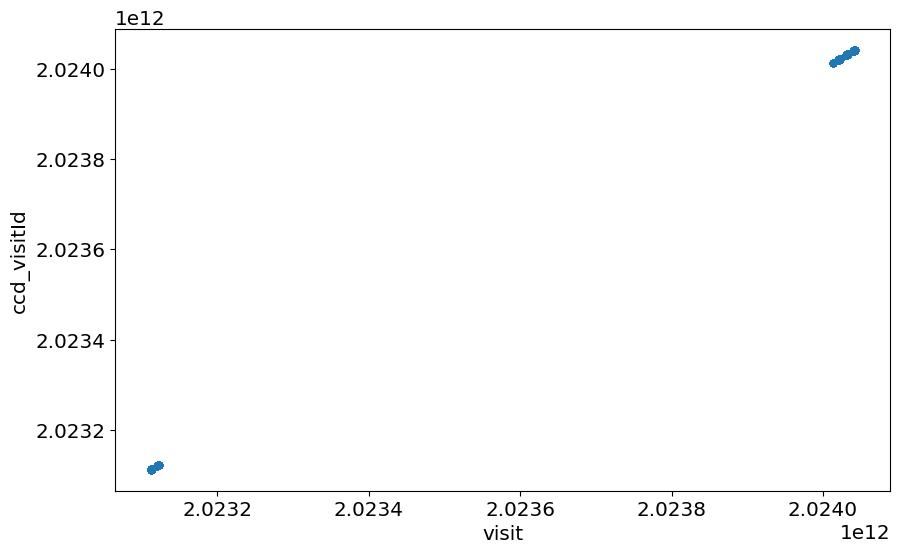

In [70]:
dataJoined.plot.scatter(x="visit",y="ccd_visitId") 

In [71]:
#dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
#dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
#dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
#dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
#dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
#dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
#dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
#dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
#dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
#dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
#dataJoined["localPhotoCalib"] = dataJoined.apply(lambda x: localPhotoCalibDict[x["visit"]], axis=1)
#dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)
#dataJoined["seeing"] = dataJoined.apply(lambda x: seeingDict[x["visit"]], axis=1)
#dataJoined["DZP"] = dataJoined.apply(lambda x: DZPDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [72]:
matchedObjIdList = list(set(dataJoined["obj_index"]))

In [73]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,179300073413279748,1.580155e+06,12859.257891,False,1.024903,0.0,0.0,True,False,1.623147e+06,16479.172165,False,44.601713,0.08864,False,3,2023121500478,0,122.61631,-36.190488,SDSSz_65mm~empty,z,35950.336609,617.848502,3577.16151,50.744821,37540.27608,870.651651,False,0.283571,False,3,520,122.880748,15.903251,0.008836,1.603447e+06,27557.101564,15.887364,0.01866,20.026629,0.973513,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [74]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [75]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,179300073413279748,1.580155e+06,12859.257891,False,1.024903,0.0,0.0,True,False,1.623147e+06,16479.172165,False,44.601713,0.08864,False,3,2023121500478,0,122.61631,-36.190488,SDSSz_65mm~empty,z,35950.336609,617.848502,3577.16151,50.744821,37540.27608,870.651651,False,0.283571,False,3,520,122.880748,15.903251,0.008836,1.603447e+06,27557.101564,15.887364,0.01866,20.026629,0.973513,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273,-289.071008,-6.930543,41.679035,-14.65813,16.119924


In [76]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,179300073413279748,1.580155e+06,12859.257891,False,1.024903,0.0,0.0,True,False,1.623147e+06,16479.172165,False,44.601713,0.08864,False,3,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35950.336609,617.848502,3577.161510,50.744821,37540.276080,870.651651,False,0.283571,False,3,520,122.880748,15.903251,0.008836,1.603447e+06,27557.101564,15.887364,0.018660,20.026629,0.973513,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.051613,-0.051273,-289.071008,-6.930543,41.679035,-14.658130,16.119924
1,179300073413279762,1.722274e+06,13896.409761,False,1.008761,0.0,0.0,True,False,1.720439e+06,15854.387410,False,43.825502,0.08864,False,17,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38142.817947,714.174432,2641.422054,117.690518,36449.190848,1007.305025,False,-0.155558,False,17,270,123.936603,15.809745,0.008760,1.671628e+06,31299.052698,15.842151,0.020329,19.914062,1.001067,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.020762,-0.049820,-190.569969,-6.295061,-2.146178,-3.282275,-4.634251
2,179300073413279801,1.061165e+07,34913.067517,False,1.015366,0.0,0.0,True,False,1.067569e+07,39481.891718,False,44.669276,0.08864,False,56,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236933.203217,805.869427,3531.742421,313.696491,241064.481355,1040.035058,False,1.082012,False,56,654,303.944893,13.835543,0.003572,1.058363e+07,35997.603672,13.838413,0.003693,17.960565,0.994001,42748468736,2023121500478,z,21.000441,27.295219,4.229468,13.34357,8.061932,0.02784,0.02784,58,-0.002926,0.000457,0.017165,0.014529,-0.000798,0.063468,0.015093,0.640831,2102.7854,0.287298,0.055902,2.248274,0.076196,-36.139215,0,0.953239,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496869,-36.086718,1.071148,0.002961,0.050000,-0.044298,-194.252512,-15.049359,32.998216,-11.588062,11.746524
3,179300

## Check the correlation between the flux psf and apperture flux

### Compute DPZ

In [77]:
#dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
#dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

In [78]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["localPhotoCalibMagErr"] =   2.5/np.log(10.0)*dataJoined["localPhotoCalibErr"].values/dataJoined["localPhotoCalib"].values
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [79]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP","localPhotoCalibMagErr","x","y"]].copy()

In [80]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

,obj_index,sourceId,band,visit,ra,dec,psfMag,psfFlux,gaussianFlux,apFlux_35_0_calFlux,apFlux_35_0_calMag,apFlux_35_0_instFlux,psfFlux_apCorr,psfMagErr,psfFluxErr,gaussianFluxErr,apFlux_35_0_calFluxErr,apFlux_35_0_calMagErr,apFlux_35_0_instFluxErr,skyBg,zeroPoint,localPhotoCalib,localPhotoCalibMag,DZP,localPhotoCalibMagErr,x,y
8758,1,178244578757837045,g,2023111500512,122.513230,-36.180948,17.030920,5.592834e+05,5.572941e+05,5.807271e+05,16.990070,26556.299779,1.010473,0.011085,5709.921854,6803.256320,11352.740964,0.021225,519.154017,2.841207,28.055744,21.867771,28.050489,-0.005255,0.001670,3961.957745,2046.783036
11431,1,178420351368167678,g,2023112000373,122.513233,-36.180938,17.013587,5.682836e+05,5.684265e+05,5.822975e+05,16.987138,27357.577159,1.021064,0.012366,6472.242640,7045.308062,11313.501940,0.021095,531.532447,5.211820,28.077291,21.284687,28.079832,0.002540,0.003553,3805.428084,2999.781436
71295,1,178983149923991858,g,2023120600232,122.513235,-36.180947,17.000594,5.751251e+05,5.854796e+05,5.875827e+05,16.977328,27292.165430,1.030670,0.011836,6269.416615,7299.202145,11436.684140,0.021133,531.213554,3.080268,28.062841,21.529353,28.067423,0.004581,0.002542,3970.076552,3204.289850
44923,1,179264657112957247,g,2023121400262,122.513226,-36.180947,17.024933,5.623758e+05,5.704769e+05,5.773548e+05,16.996393,26748.304936,1.012413,0.011426,5918.171713,6994.988599,11300.582989,0.021251,523.545389,2.928750,28.050276,21.584724,28.064634,0.014358,0.002427,3810.291889,3058.449402
45023,1,179264661407924547,g,2023121400266,122.513238,-36.180947,17.046889,5.511175e+05,5.611757e+05,5.838535e+05,16.984240,27440.281369,1.002426,0.011510,5842.467954,6512.160497,11642.931556,0.021651,547.201177,2.896505,28.061768,21.277241,28.080212,0.018444,0.001966,3254.304051,3066.812895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57425,1364,182959270659096802,y,2024032800499,122.390849,-36.217244,12.584384,3.359281e+07,3.397341e+07,3.391015e+07,12.574176,227401.015997,1.014459,0.005169,159936.542951,170442.963631,112414.427261,0.003599,753.849644,11.522109,25.972031,149.120489,25.966157,-0.005874,0.004249,324.767254,1990.399756
67468,1366,178455686064111637,y,2023112100513,122.519842,-36.268801,11.955075,5.997494e+07,6.094416e+07,6.086290e+07,11.939118,502282.124479,1.018664,0.005141,283988.034777,304279.808441,115096.901503,0.002053,949.858021,12.209390,26.203732,121.172743,26.191488,-0.012244,0.004726,2859.521941,158.086512
67514,1366,178455690359078931,y,2023112100517,122.519839,-36.268803,11.985590,5.831284e+07,5.772436e+07,5.913185e+07,11.970446,500365.006710,1.018789,0.003791,203593.542987,217988.901275,110144.680842,0.002022,932.028104,12.294842,26.228031,118.177424,26.218664,-0.009367,0.003195,2303.815514,167.763923
696,1366,179300091666890762,y,2023121500495,122.519844,-36.268800,11.901343,6.301773e+07,6.330654e+07,6.244554e+07,11.911246,481211.541182,1.022761,0.004671,271083.366114,283429.026447,121474.731260,0.002112,936.096375,11.284307,26.129723,129.767334,26.117087,-0.012636,0.004234,2876.485837,80.308061


In [81]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

### Histogram on calibration

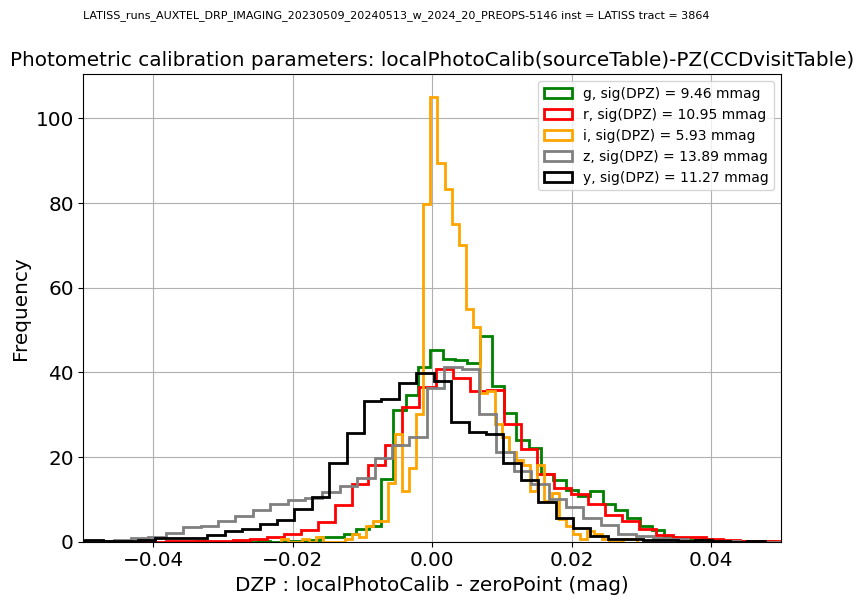

In [82]:
all_dpz_std = []
all_labels = []
fig,ax = plt.subplots(1,1,figsize=(8,6))

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_g["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="g",lw=2,label=label)

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_r["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="r",lw=2,label=label)

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_i["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="orange",lw=2,label=label)

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_z["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="grey",lw=2,label=label)

std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_y["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="k",lw=2,label=label)

ax.set_xlabel("DZP : localPhotoCalib - zeroPoint (mag)")
ax.set_xlim(-0.05,0.05)
ax.grid()
ax.legend()
ax.set_title("Photometric calibration parameters: localPhotoCalib(sourceTable)-PZ(CCDvisitTable)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

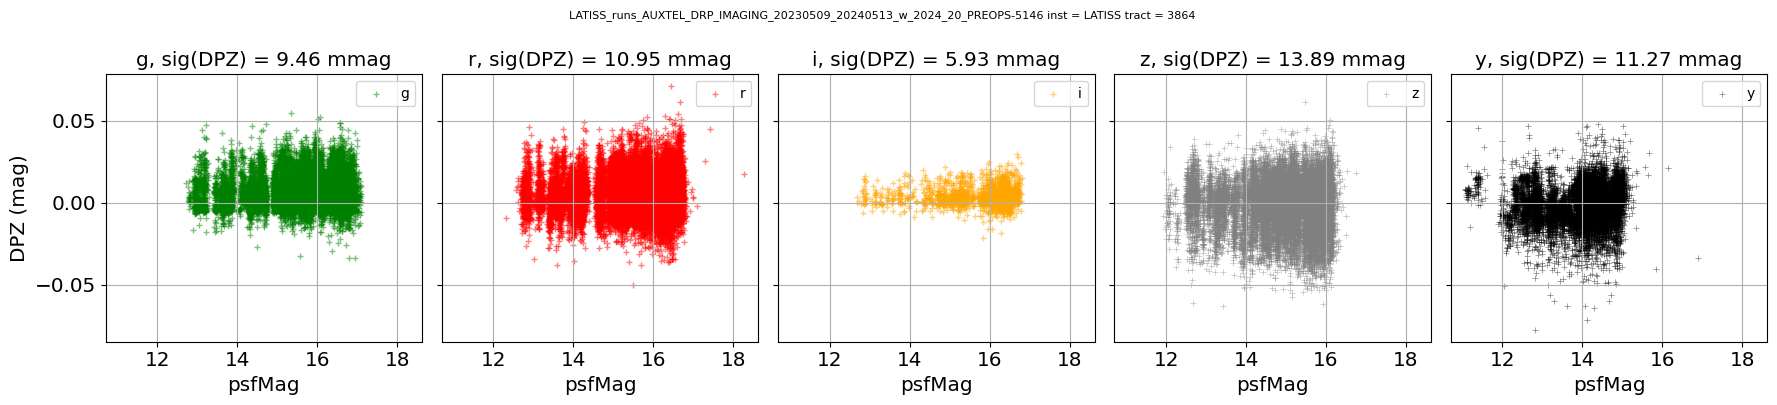

In [83]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [84]:
all_localPhotoCalibMagErr_aver = []
all_labels = []

aver = dataJoined_subset_g["localPhotoCalibMagErr"].mean()*1000
label = f"g, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_r["localPhotoCalibMagErr"].mean()*1000
label = f"r, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_i["localPhotoCalibMagErr"].mean()*1000
label = f"i, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_z["localPhotoCalibMagErr"].mean()*1000
label = f"z, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_y["localPhotoCalibMagErr"].mean()*1000
label = f"y, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 


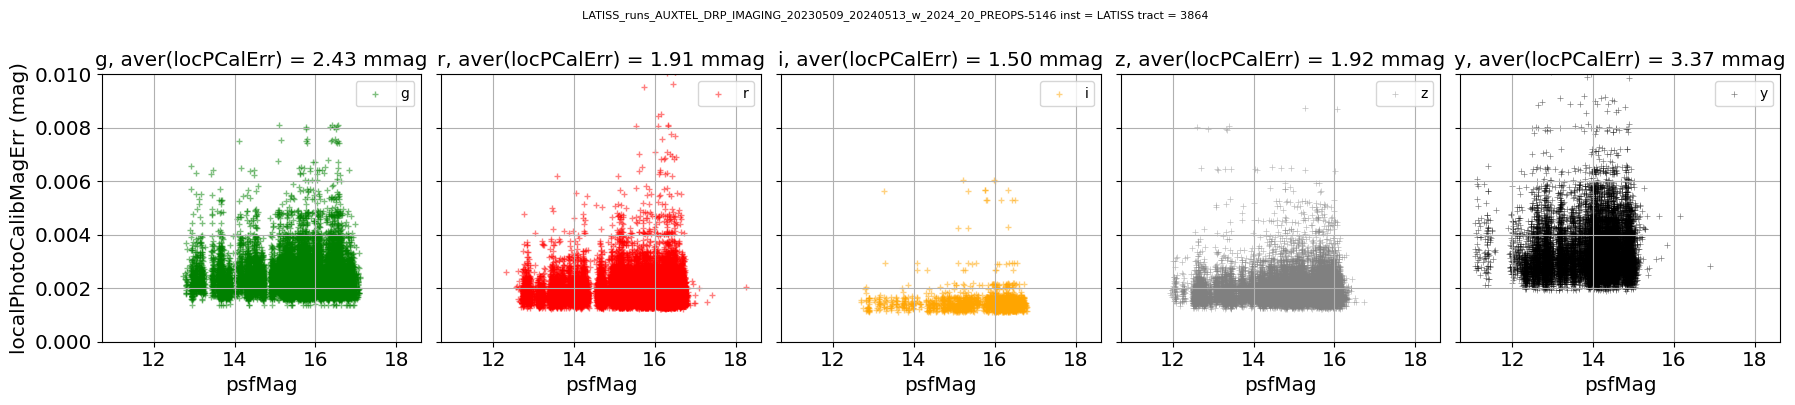

In [85]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("localPhotoCalibMagErr (mag)")
ax1.set_ylim(0.,0.01)
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

## Non uniformity on CCD

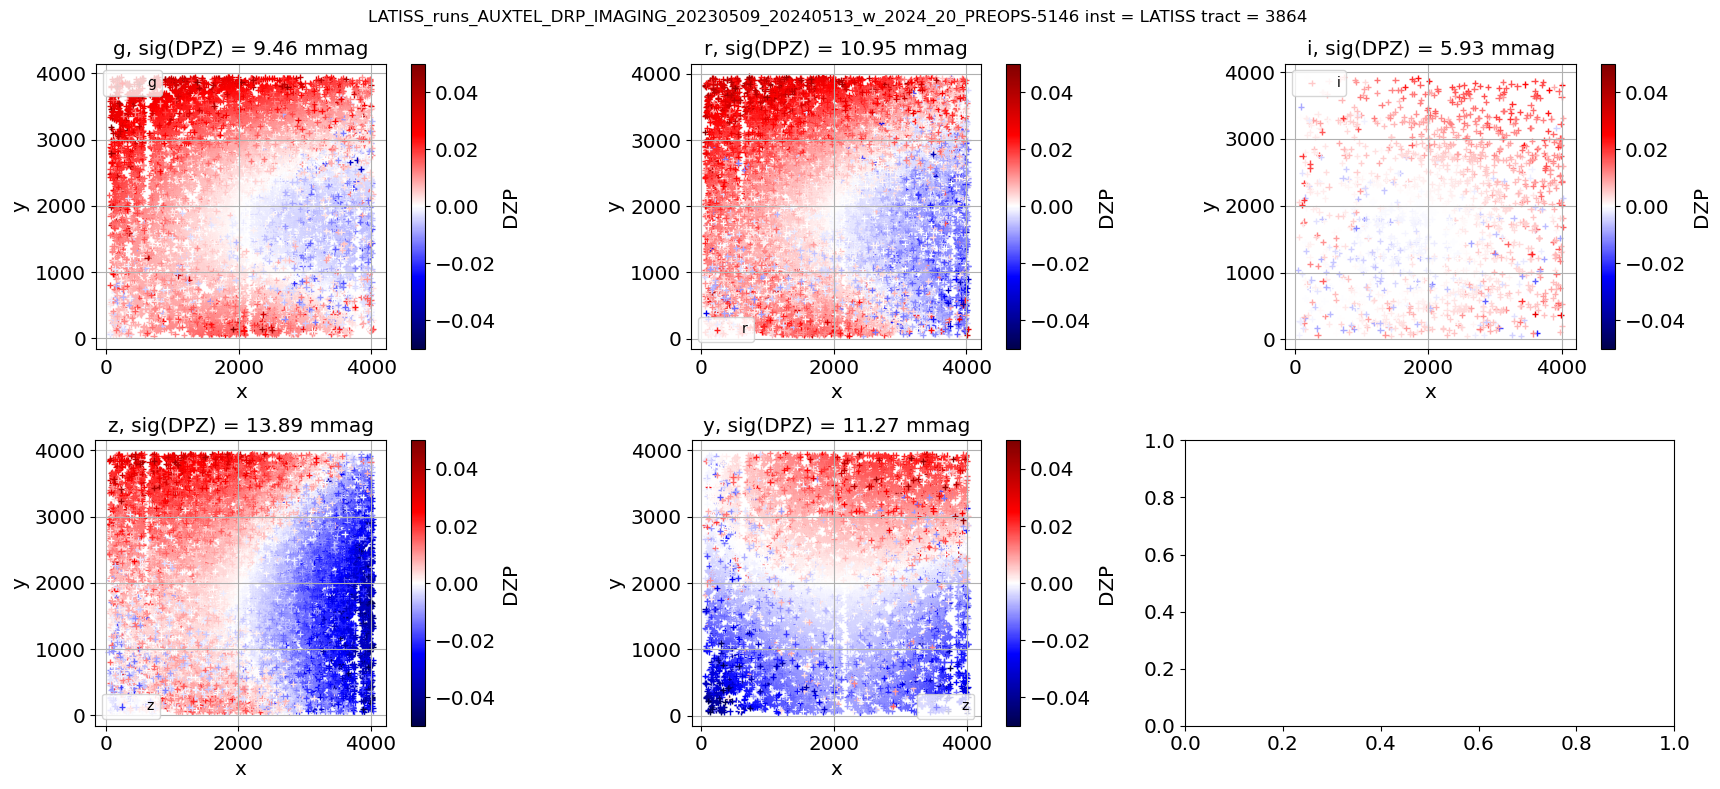

In [86]:
fig,axs = plt.subplots(2,3,figsize=(18,8))
ax1,ax2,ax3,ax4,ax5 = axs[0,0], axs[0,1],axs[0,2],axs[1,0],axs[1,1]

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_g.plot.scatter(x="x",y="y",ax=ax1,marker="+",lw=1,c="DZP",cmap="seismic",label="g",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax1.set_aspect("equal")

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_r.plot.scatter(x="x",y="y",ax=ax2,marker="+",lw=1,c="DZP",cmap="seismic",label="r",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax2.set_aspect("equal")

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_i.plot.scatter(x="x",y="y",ax=ax3,marker="+",lw=1,c="DZP",cmap="seismic",label="i",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax3.set_aspect("equal")

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_z.plot.scatter(x="x",y="y",ax=ax4,marker="+",lw=1,c="DZP",cmap="seismic",label="z",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax4.set_aspect("equal")


std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_y.plot.scatter(x="x",y="y",ax=ax5,marker="+",lw=1,c="DZP",cmap="seismic",label="z",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax5.set_aspect("equal")


plt.suptitle(suptitle)
plt.tight_layout()

Text(0, 0.5, '$\\Delta ZP \\, (mag)$')

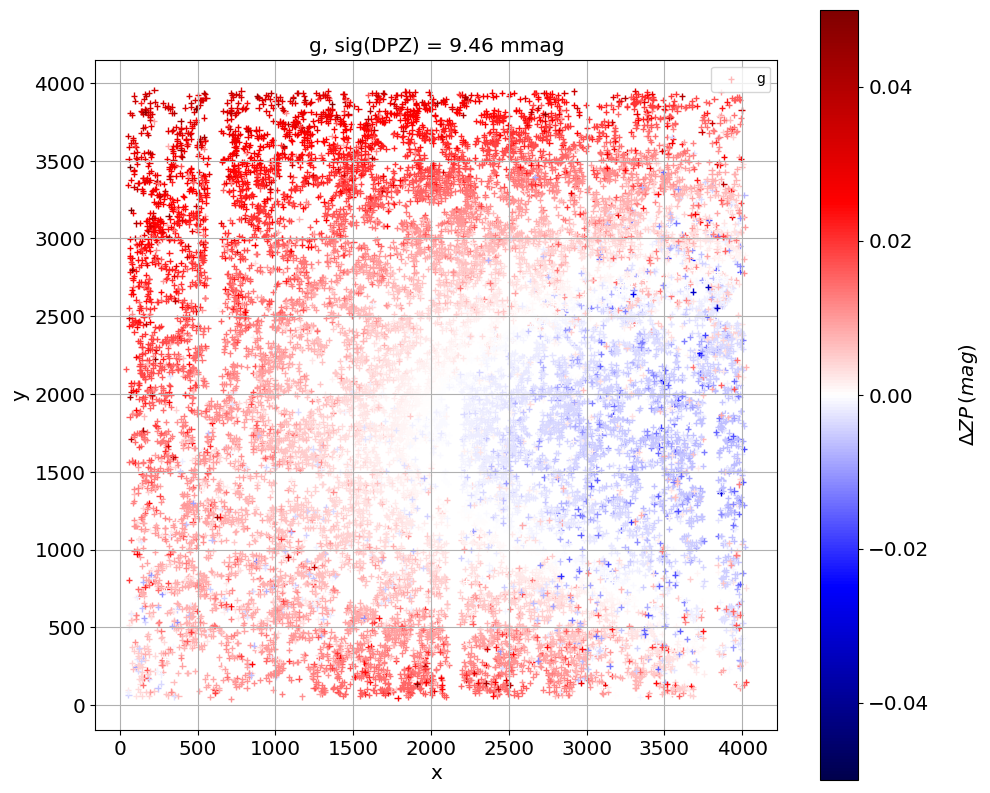

In [92]:
fig,ax = plt.subplots(1,1,figsize=(11,10))
std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_g.plot.scatter(x="x",y="y",ax=ax,marker="+",lw=1,c="DZP",cmap="seismic",label="g",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax.set_aspect("equal")
im = ax.images  
cb = ax.collections[-1].colorbar
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('$\Delta ZP \, (mag)$', rotation=90.)

In [89]:
ax.collections[-1]

In [ ]:
fig,axs = plt.subplots(5,1,figsize=(10,50))
ax1,ax2,ax3,ax4,ax5 = axs[0], axs[1],axs[2],axs[3],axs[4]

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_g.plot.scatter(x="x",y="y",ax=ax1,marker="+",lw=1,c="DZP",cmap="seismic",label="g",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax1.set_aspect("equal")
#ax1.collections[-1].colorbar(fraction=0.046, pad=0.04)

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_r.plot.scatter(x="x",y="y",ax=ax2,marker="+",lw=1,c="DZP",cmap="seismic",label="r",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax2.set_aspect("equal")

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_i.plot.scatter(x="x",y="y",ax=ax3,marker="+",lw=1,c="DZP",cmap="seismic",label="i",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax3.set_aspect("equal")

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_z.plot.scatter(x="x",y="y",ax=ax4,marker="+",lw=1,c="DZP",cmap="seismic",label="z",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax4.set_aspect("equal")


std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_y.plot.scatter(x="x",y="y",ax=ax5,marker="+",lw=1,c="DZP",cmap="seismic",label="z",title=label,grid=True,alpha=1,colorbar=True,vmin=-0.05,vmax=0.05)
ax5.set_aspect("equal")


plt.suptitle(suptitle)
plt.tight_layout()

### Check visit by visit in each filter

In [ ]:
NROWS = 10
NCOLS = 3
NIMGS = NROWS*NCOLS
index0 = 0

#### In green filter

In [ ]:
listofvisits = dataJoined_subset_g["visit"].unique()
listofvisits = sorted(listofvisits)

In [ ]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))
for index,ax in enumerate(axs.flatten()):
    the_visit = listofvisits[index]
    df =  dataJoined_subset_g[dataJoined_subset_g["visit"] == the_visit ]
    std = df["DZP"].std()*1000
    label = f"{the_visit},{std:.2f}"
    df.plot.scatter(x="x",y="y",ax=ax,marker="o",lw=1,c="DZP",cmap="seismic",title=label,grid=True,alpha=1,colorbar=False,vmin=-0.05,vmax=0.05)
    ax.set_aspect("equal")

plt.suptitle(suptitle)
plt.tight_layout()

### In red filter

In [ ]:
listofvisits = dataJoined_subset_r["visit"].unique()
listofvisits = sorted(listofvisits)

In [ ]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))
for index,ax in enumerate(axs.flatten()):
    the_visit = listofvisits[index]
    df =  dataJoined_subset_r[dataJoined_subset_r["visit"] == the_visit ]
    std = df["DZP"].std()*1000
    label = f"{the_visit},{std:.2f}"
    df.plot.scatter(x="x",y="y",ax=ax,marker="o",lw=1,c="DZP",cmap="seismic",title=label,grid=True,alpha=1,colorbar=False,vmin=-0.05,vmax=0.05)
    ax.set_aspect("equal")

plt.suptitle(suptitle)
plt.tight_layout()

## In Z filter

In [ ]:
listofvisits = dataJoined_subset_z["visit"].unique()
listofvisits = sorted(listofvisits)

In [ ]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))
for index,ax in enumerate(axs.flatten()):
    the_visit = listofvisits[index]
    df =  dataJoined_subset_z[dataJoined_subset_z["visit"] == the_visit ]
    std = df["DZP"].std()*1000
    label = f"{the_visit}, {std:.2f}"
    df.plot.scatter(x="x",y="y",ax=ax,marker="o",lw=1,c="DZP",cmap="seismic",title=label,grid=True,alpha=1,colorbar=False,vmin=-0.05,vmax=0.05)
    ax.set_aspect("equal")

plt.suptitle(suptitle)
plt.tight_layout()

## In Y filter

In [ ]:
listofvisits = dataJoined_subset_y["visit"].unique()
listofvisits = sorted(listofvisits)

In [ ]:
fig,axs = plt.subplots(NROWS,NCOLS,figsize=(NCOLS*3,NROWS*3))
for index,ax in enumerate(axs.flatten()):
    the_visit = listofvisits[index]
    df =  dataJoined_subset_y[dataJoined_subset_y["visit"] == the_visit ]
    std = df["DZP"].std()*1000
    label = f"{the_visit}, {std:.2f}"
    df.plot.scatter(x="x",y="y",ax=ax,marker="o",lw=1,c="DZP",cmap="seismic",title=label,grid=True,alpha=1,colorbar=False,vmin=-0.05,vmax=0.05)
    ax.set_aspect("equal")

plt.suptitle(suptitle)
plt.tight_layout()